## Contents: <a class="anchor" id="Top"></a>

* [1. Approach - I](#1)
    * [1.1 Data Cleaning](#1.1)
    * [1.2 Data Analysis - Understanding the data](#1.2)
    * [1.3  Data Pre-processing](#1.3)
    * [1.4  Model Evaluation](#1.4)
        * [1.4.1 Baseline Model (Dummy Regressor) Hits](#1.4.1)
        * [1.4.2 Linear Regression](#1.4.1)
* [2. Approach - II](#2)
* [2.1 Feature Generation](#2.1)
* [2.2 Data Analysis / Visualisation](#2.2)
* [2.3 Data Pre-processing ](#2.3)
* [2.4 Model Evaluation](#2.4)
    * [2.4.1 Baseline Model (Dummy Regressor) Hits](#2.4.1)
    * [2.4.2 Linear Regression](#2.4.2)
    * [2.4.3 Decision Tree](#2.4.3)
* [3. Approach - III](#3)
    * [3.1 Model Evaluation](#3.1)
         * [3.1.1 Logistic Regression](#3.1.1)
* [4. Unseen Data (Real - Test set)](#4)
    * [4.1 Model Performance on Unseen Data)](#4.1)
* [5. Optimum TPH](#5)
    * [5.1 Optimum TPH per Day](#5.1)
    * [5.2 Optimum TPH per Month](#5.2)
    * [5.3 Optimum TPH per Year](#5.3)
* [6. Conclusion](#6)
    
                               



---
## Introduction

> **The Scenario** 
> - For every 15 minutes an average queue over 5 minutes results in a "hit". The maximum hits per day is 4 and the maximum hits per month is 120. In order to efficiently manage the queue, the airport uses lanes to minimize the queues. These lanes are dependant on the number of Trays per hour (TPH) per lane. The higher the TPH per lane the lesser the total number of lanes opened. 

> **The Problem**
> - Determining the optimum TPH to meet the target of 4 daily hits.

> **My Intuition**
> - This problem can be considered as a regression or a classification problem. I will be using 3 approaches:
>> - Regression without feature extraction
>> - Regression with feature extraction
>> - Classification with feature extraction
> - Based on the results, I will be choosing which model to choose and test with a sample of unseen data to get the optimum TPH. 

**Note: To directly skip to the answer click on these ->** [TPH per day](#5.1) | [TPH per Month](#5.1) |  [TPH per Year](#5.1)

### Important Info
Comments are written after **"#"** in each code block making it easier to understand the code. The whole process is documented.


In [1]:
# an example comment explaining the code block
x =1 # an example comment explaining the code 
y = 2
x+y

3

[Back to Contents](#Top)

---
## Libraries

Importing all the libraries required.

In [2]:
# Ignore Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data Visualisation and Manipulation Libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

# Data Preprocessing Libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Regression Model Libraries
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Classification Model Libraries
from sklearn.linear_model import LogisticRegression


# Evaluation Metric Libraries
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Regression metrics
from sklearn.metrics import classification_report, confusion_matrix  # Classification Metrics

# Correlation Metric Libraries
from scipy.stats import pearsonr

# Hyperparameter Tuning Libraries
import math
import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

[Back to Contents](#Top)

---
## 1. Approach - I <a class="anchor" id="1"></a>

> Solving a regression problem with no additional features generated.

In [3]:
df1 = pd.read_excel("/Users/bharathsimha/Desktop/Gatwick/1.xlsx") # loading the dataset

In [4]:
df1.head() # preview of the data

,Date,TPH,Hits
0,2022-05-01,750,4
1,2022-05-02,750,8
2,2022-05-03,750,0
3,2022-05-04,750,6
4,2022-05-05,750,2


In [5]:
len(df1) # length of the data 

236

In [6]:
df1.info() # information about the columns and data in the data set 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    236 non-null    datetime64[ns]
 1   TPH     236 non-null    int64         
 2   Hits    236 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 5.7 KB


> We determine the dependent and independednt features:
> - TPH is an independent feature (column)
> - Hits is a dependent feature (column)
> - Hits is the target feature (column)
> - The target feature (Hits) is of continuous data which means it is a regression problem. 

[Back to Contents](#Top)

---
## 1.1 Data Cleaning <a class="anchor" id="1.1"></a>

In [7]:
# Lets find out how many 15 minutes are there in a day

hours = 24
interval = 4     # 15 minute interval in 1 hour
print(f"There are {hours * interval} intervals of 15 minutes in a day")

There are 96 intervals of 15 minutes in a day


In [8]:
# 1 hit is in a 15 minute interval 
# So if there are greater than 96 intervals in a day there is a chance that something is wrong with the data

df1[df1["Hits"] > 96]

,Date,TPH,Hits


In [9]:
# Checking for null values

df1.isna().any()

Date    False
TPH     False
Hits    False
dtype: bool

In [10]:
# Checking for duplicate values (already checked in excel, verifying again in python)

df1.duplicated().any()

False

In [11]:
df1.duplicated(subset=["Date"]).any()

False

> **Observations**
> - No data corruption or false collected data found
> - There are no null values in the dataset
> - There are no duplicate values in the date feature 
> - `The data is clean`



[Back to Contents](#Top)

---
## 1.2 Data Analysis - Understanding the data <a class="anchor" id="1.2"></a>

In [12]:
# maximum hits 

df1["Hits"].max(), df1[df1["Hits"]==57]

(57,
          Date  TPH  Hits
 59 2022-06-29  750    57
 63 2022-07-03  750    57)

Text(0.5, 1.0, 'Distribution of Hits')

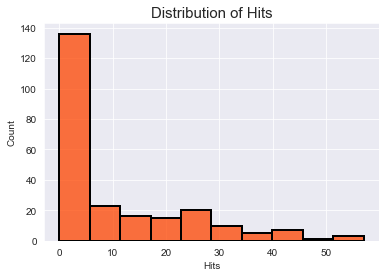

In [13]:
## Continuous Variables
# plot to understand the distributon of hits (bins) in the data
sns.histplot(data=df1, x ="Hits", 
             bins = 10, stat = "count", color = "orangered", 
             edgecolor = "black", linewidth = 2).set_title("Distribution of Hits", fontsize = 15)

> An observation from the above plot is that the target variable (Hits) has a **skewed distribution** **(Right Skewed)** than a normal distribution. 

In [14]:
# calculating the distribution of hits in the data from the above plot

df1[df1["Hits"]<=4].count(), df1[(df1["Hits"]>4)].count()

(Date    129
 TPH     129
 Hits    129
 dtype: int64,
 Date    107
 TPH     107
 Hits    107
 dtype: int64)

In [15]:
print(f'The number of hits less than and equal to 4 in the data = {round((129/len(df1)) * 100,2)}%')# Percentage calc
print(f'The number of hits greater than 4 in the data = {100 - round((129/len(df1)) * 100,2)}%')# Percentage calc

The number of hits less than and equal to 4 in the data = 54.66%
The number of hits greater than 4 in the data = 45.34%


Text(0.5, 1.0, 'Distribution of Hits')

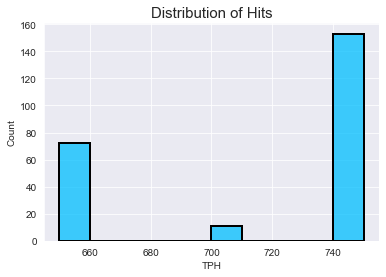

In [16]:
# Plot to understand the distribution of TPH in the data 
sns.histplot(data=df1, x ="TPH", 
             bins = 10, stat = "count", color = "deepskyblue", 
             edgecolor = "black", linewidth = 2).set_title("Distribution of Hits", fontsize = 15)

In [17]:
# calculating the distribution of TPH in the data from the above plot

df1["TPH"].unique() # there are 3 unique TPH values in the data

array([750, 650, 700])

In [18]:
df1[df1["TPH"]==750].count(), df1[(df1["TPH"]==700)].count(), df1[(df1["TPH"]==650)].count()

(Date    153
 TPH     153
 Hits    153
 dtype: int64,
 Date    11
 TPH     11
 Hits    11
 dtype: int64,
 Date    72
 TPH     72
 Hits    72
 dtype: int64)

In [19]:
print(f'The distribution of 750 TPH per lane in the data = {round((153/len(df1)) * 100,2)}%')# Percentage calc
print(f'The distribution of 700 TPH per lane in the data = {round((11/len(df1)) * 100,2)}%')# Percentage calc
print(f'The distribution of 650 TPH per lane in the data = {round((72/len(df1)) * 100,2)}%')# Percentage calc

The distribution of 750 TPH per lane in the data = 64.83%
The distribution of 700 TPH per lane in the data = 4.66%
The distribution of 650 TPH per lane in the data = 30.51%


[Text(0.5, 1.0, 'TPH vs Hits')]

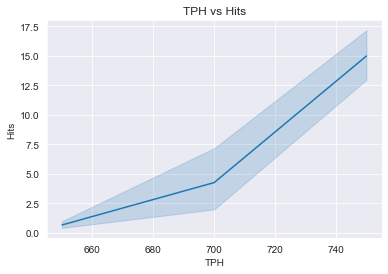

In [20]:
# Plot to understand the distribution of Hits vs TPH

sns.lineplot(data = df1, x = "TPH", y = "Hits").set(title='TPH vs Hits')


> In the question, there was an observation that a planning assumption of **750 trays per hour** (750 TPH) results in a **higher** than acceptable amount of daily **hits** and on the other hand, a plannning assumption of **650 TPH** results in **virtually no hits**. `The plot above shows a similar pattern to the observation.` 

In [21]:
# distribution of Hits in TPH analysis

df1[(df1["TPH"]==750) & (df1["Hits"]<=4)].count(), df1[(df1["TPH"]==700) & (df1["Hits"]<=4)].count(), df1[(df1["TPH"]==650) & (df1["Hits"]<=4)].count()

(Date    52
 TPH     52
 Hits    52
 dtype: int64,
 Date    7
 TPH     7
 Hits    7
 dtype: int64,
 Date    70
 TPH     70
 Hits    70
 dtype: int64)

In [22]:
print(f'The distribution of Hits <=4 in 750 TPH = {round((52/153) * 100,2)}%')# Percentage calc
print(f'The distribution of Hits <=4 in 700 TPH = {round((7/11) * 100,2)}%')# Percentage calc
print(f'The distribution of Hits <=4 in 650 TPH = {round((70/72) * 100,2)}%')# Percentage calc

The distribution of Hits <=4 in 750 TPH = 33.99%
The distribution of Hits <=4 in 700 TPH = 63.64%
The distribution of Hits <=4 in 650 TPH = 97.22%


> The above analysis  also supports the observation of higher the TPH, higher the Hits. 

Text(0.5, 1.0, 'Boxplot of Hits (Outlier Detection)')

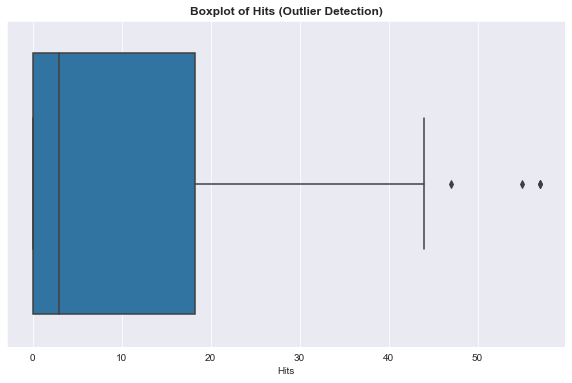

In [23]:
# Checking for any possible outliers 

plt.figure(figsize=(10,6))
sns.boxplot(df1["Hits"])
plt.title("Boxplot of Hits (Outlier Detection)",fontweight="bold")

In [24]:
# outlier detection

outliers=[]
def detect_outlier(data_1): # function to detect the outliers in the data
    
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

detect_outlier(df1["Hits"])

[57, 57, 55]

> Here the boxplot does show outliers below 50 hits which is not captured by the function. So I have to find it manually.

In [25]:
df1.drop(df1[df1["Hits"]>45].index,inplace=True) # Finding and dropping the outliers

In [26]:
df1[df1["Hits"]>45] # outliers dropped

,Date,TPH,Hits


> **Observations**
> - After visualising the data through various plots and conducting different analysis, these are the observations:
>> - The maximum observed hits are 57 on two days 29th June and 03rd July both were in the 750 TPH.
>> - The target variable (Hits) distribution is right skewed.
>> - 54.6% of the data did not cross the 4 hits limit per day. 
>> - About 65% of the data has 750 TPH followed by 650 TPH of 30.5%, and 700 TPH of 4.6%.
>> - Although 65% of data has 750 TPH, Only 33.9% of all the Hits in 750 TPH did not cross the limit. 
>> - 97.2% of all the Hits in 650 TPH did not cross the limit (<=4), supporting the observation of TPH being  proportional to Hits.
>> - There were 3 outliers found in the data, which have been dropped.
>> - `Data Analysis is done`

[Back to Contents](#Top)

---
## 1.3 Data Pre-processing <a class="anchor" id="1.3"></a>

Text(0.5, 1.0, 'Correlation Plot')

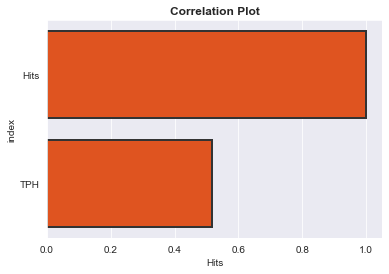

In [27]:
# Correlation plot

correlation = pd.DataFrame(df1.corr()).reset_index().sort_values(by = 'Hits',ascending = False)
sns.barplot(x = 'Hits',y = 'index',data = correlation,color="orangered",linewidth=2,edgecolor=".2")
sns.set(rc = {'figure.figsize':(8,8)})
plt.title("Correlation Plot",fontweight="bold")


> - A positive correlation between two features:
>> -  They are **directly proportional** to the target feature i.e if x (feature) increases y (target) also increases. The higher the correlation the stronger the proportionality.
> - To measure the strength and significance of correlation, correlation analysis is used. 

In [28]:
# Correlation analysis

# calculate Pearson's correlation
corr, _ = pearsonr(df1["TPH"], df1["Hits"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.516


> The correlation score is greater than 0.5 which means there is **strong positive linear relationship** between TPH and Hits. This also supports the observation made about TPH being proportional to Hits. `Data Preprocessing is done`.

---

[Back to Contents](#Top)

## 1.4 Model Evaluation <a class="anchor" id="1.4"></a>


> I will be considering 2 different models:
> - Dummy Regressor baseline
> - Linear Regression

I will evaluate the models and select the best one. 

In [29]:
# X  = Other features, Y = Target feature
X = df1["TPH"]
Y = df1["Hits"]


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42) # train - test split

print("The train test split (90:10):",x_train.shape, x_test.shape)

The train test split (90:10): (208,) (24,)


In [30]:
# Data is divided into x train and y train 
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

---
## 1.4.1 Baseline Model (Dummy Regressor) Hits <a class="anchor" id="1.4.1"></a>

- Regressor that makes predictions using simple rules.

In [31]:
dummy_regr = DummyRegressor() # instantiating the regressor
dummy_regr.fit(x_train, y_train) # fitting the train to the model 

pred_tr = dummy_regr.predict(x_train)

#scores
print("Training Set:")
print(f'R2 score = {r2_score(y_train,pred_tr)}') 


Training Set:
R2 score = 0.0


Text(0.5, 1.0, 'Residual Plot')

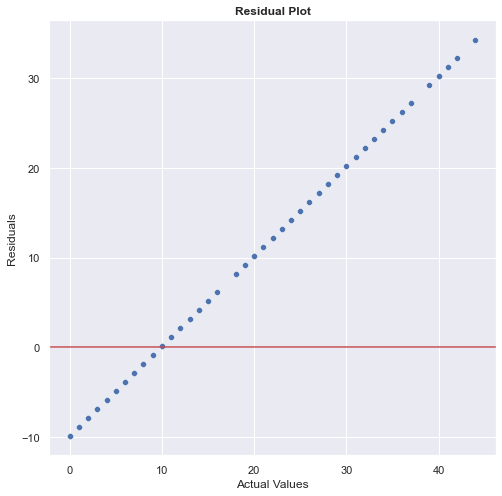

In [32]:
residuals = y_train - pred_tr # residuals 

sns.scatterplot(x=y_train,y=residuals)
y = np.linspace(0,3500,100)
x = np.linspace(0,0)
plt.axhline(y=0, color='r', linestyle='-')
sns.set(rc = {'figure.figsize':(6,6)})
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residual Plot",fontweight="bold")

- As it can be seen from the above results. The Dummy Regressor always predict the r2_ score as 0, since it is always predicting a constant (mean) without having an insight of the output. ( In general, best r2_score is 1 and Constant r2_score is 0).
- The predicted values does not change as it always predicts the same value. 

[Back to Contents](#Top)

---
## 1.4.2 Linear Regression <a class="anchor" id="1.4.2"></a>

In [33]:
lr = LinearRegression()
lr.fit(x_train.reshape(-1,1),y_train)

pred_lr = lr.predict(x_train.reshape(-1,1))
pred_lr_test = lr.predict(x_test.reshape(-1,1))
                    
print("Training Set:")
print(f'R2 score = {r2_score(y_train,pred_lr)}')

print("----------------------------------------")

print("Test Set:")
print(f'R2 score = {r2_score(y_test,pred_lr_test)}')

Training Set:
R2 score = 0.25530389841669077
----------------------------------------
Test Set:
R2 score = 0.2868344453579962


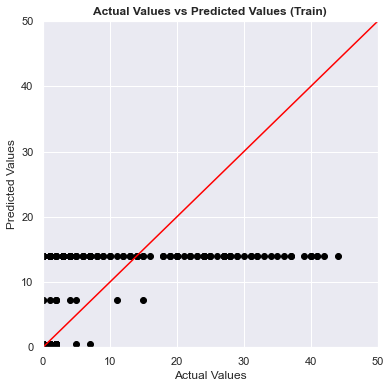

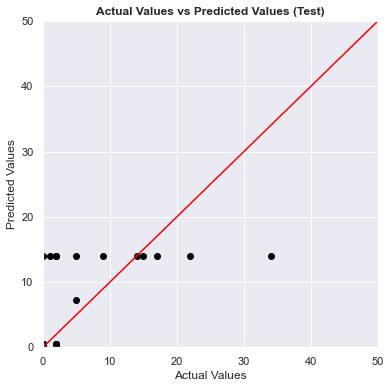

In [34]:
# Regression Plot (Linear)
plt.figure()
plt.scatter(y_train,pred_lr,color="Black") 
x = np.linspace(0,700,100)
y=x
plt.plot(x, y,color='red')
plt.ylim(0, 50)
plt.xlim(0, 50)
plt.ylabel("Predicted Values")
plt.xlabel("Actual Values")
plt.title("Actual Values vs Predicted Values (Train)",fontweight="bold")
plt.show()

plt.figure()
plt.scatter(y_test,pred_lr_test,color="Black") 
x = np.linspace(0,700,100)
y=x
plt.plot(x, y,color='red')
plt.ylim(0, 50)
plt.xlim(0, 50)
plt.ylabel("Predicted Values")
plt.xlabel("Actual Values")
plt.title("Actual Values vs Predicted Values (Test)",fontweight="bold")
plt.show()

> From the above score and plots, the model is performing poorly on the data. So, onto the next approach.

[Back to Contents](#Top)

---

# 2. Approach - II   <a class="anchor" id="2"></a>
> Solving a Regression problem with additional features generated. 

## 2.1 Feature Generation <a class="anchor" id="2.1"></a>

In [35]:
df2 = pd.read_excel("1.xlsx")
df2.head()

,Date,TPH,Hits
0,2022-05-01,750,4
1,2022-05-02,750,8
2,2022-05-03,750,0
3,2022-05-04,750,6
4,2022-05-05,750,2


In [36]:
df2.dtypes

Date    datetime64[ns]
TPH              int64
Hits             int64
dtype: object

In [37]:
# date -> month, day
df2['Day'] = df2['Date'].dt.day
df2['Month'] = df2['Date'].dt.month

In [38]:
# season feature for UK (Northern Hemisphere)

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'
    
df2['Season'] = df2['Month'].apply(get_season)

In [39]:
# Holidays

import holidays

uk_holidays = holidays.UnitedKingdom(years=2022)


df2['holidays'] = df2.Date.apply(lambda date: uk_holidays.get(date))
df2.holidays = df2.holidays.fillna('No holiday') 


In [40]:
holiday = []
for row in df2['holidays']:
    if row == "No holiday" :    
        holiday.append(0)
    else:          
        holiday.append(1)
            
df2['Holiday'] = holiday


In [41]:
# Weekday / Weekend
df2['Weekday'] = df2.Date.dt.weekday

df2["Weekday"].unique() # starts from Sunday

array([6, 0, 1, 2, 3, 4, 5])

In [42]:
week = []
for row in df2['Weekday']:
    if row <5 :    
        week.append("Weekday")
    elif row >=5:          
        week.append("Weekend")
            
df2['Week'] = week

In [43]:
# removing features that are not useful anymore
del df2["Weekday"]
del df2["holidays"]

In [44]:
df2.head()

,Date,TPH,Hits,Day,Month,Season,Holiday,Week
0,2022-05-01,750,4,1,5,Spring,0,Weekend
1,2022-05-02,750,8,2,5,Spring,1,Weekday
2,2022-05-03,750,0,3,5,Spring,0,Weekday
3,2022-05-04,750,6,4,5,Spring,0,Weekday
4,2022-05-05,750,2,5,5,Spring,0,Weekday


[Back to Contents](#Top)

---
## 2.2 Data Analysis / Visualisation <a class="anchor" id="2.2"></a>

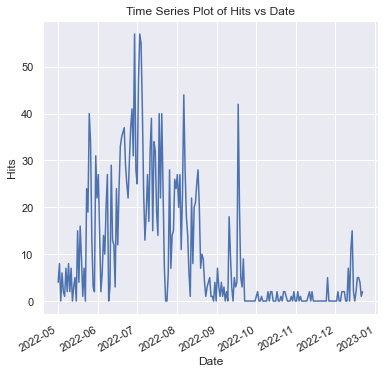

In [45]:
# Time series plot

plt.plot(df2['Date'], df2['Hits'])
plt.xlabel('Date')
plt.ylabel('Hits')
plt.title('Time Series Plot of Hits vs Date')
plt.gcf().autofmt_xdate()

Text(0.5, 1.0, 'The Count of Holiday Feature')

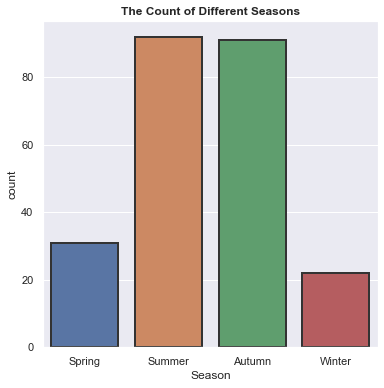

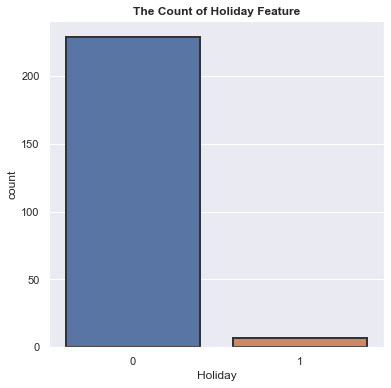

In [46]:
# Discrete Variables 
plt.figure(figsize=(6,6))
sns.countplot(x = "Season", data = df2,linewidth=2,edgecolor=".2")
plt.title("The Count of Different Seasons",fontweight="bold")

plt.figure(figsize=(6,6))
sns.countplot(x = "Holiday", data = df2,linewidth=2,edgecolor=".2")
plt.title("The Count of Holiday Feature",fontweight="bold")

**Observations**
> - Summer and Autumn have the highest counts in the data followed by Spring and Winter.
> - There are very few holidays in the data as the data set does not contain the whole year. 

Text(0.5, 1.0, 'Week Vs Hits')

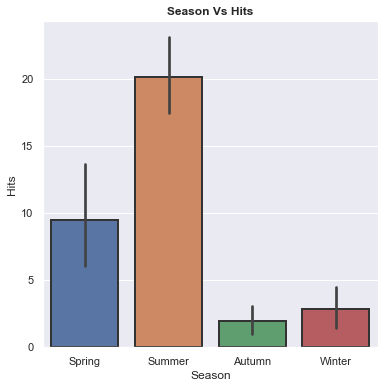

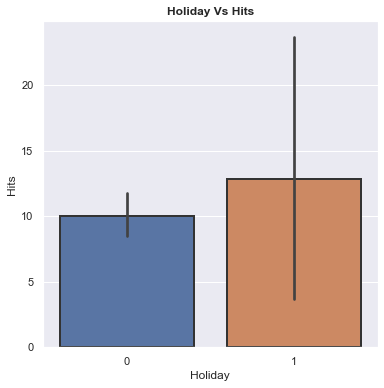

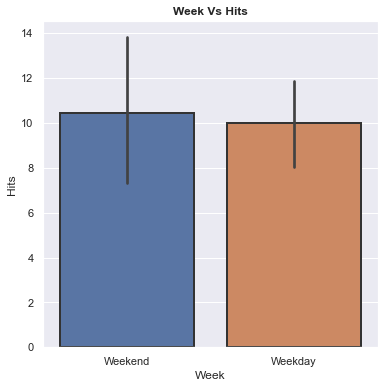

In [47]:
# Bivariate analysis with target feature
plt.figure(figsize=(6,6))
sns.barplot(x = "Season",y="Hits" ,data = df2,linewidth=2,edgecolor=".2")
plt.title("Season Vs Hits",fontweight="bold")

plt.figure(figsize=(6,6))
sns.barplot(x = "Holiday",y="Hits" ,data = df2,linewidth=2,edgecolor=".2")
plt.title("Holiday Vs Hits",fontweight="bold")


plt.figure(figsize=(6,6))
sns.barplot(x = "Week",y="Hits" ,data = df2,linewidth=2,edgecolor=".2")
plt.title("Week Vs Hits",fontweight="bold")

**Observations**
> - Although Spring season has low amount of records it has higher average hits compared to the autumn season. 
> - Even though the number of holidays in the data are less compared to the non-holidays, the average number of hits are higher in the holidays than the non-holidays. 
> - The weekday/weekend have the same amount of average hits with weekend being slightely higher than the weekdays.

Text(0.5, 1.0, 'Week Vs Hits')

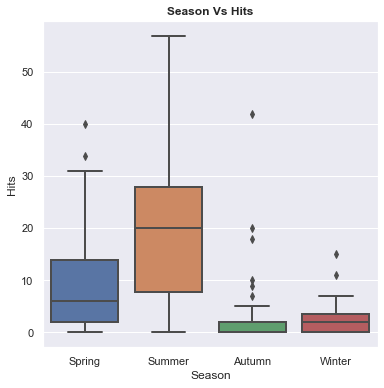

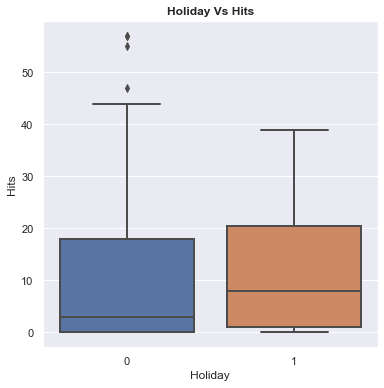

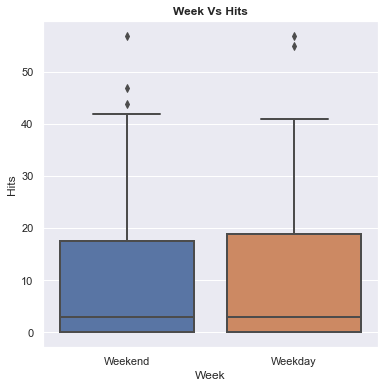

In [48]:
# Bivariate analysis with target feature
plt.figure(figsize=(6,6))
sns.boxplot(x = "Season",y="Hits" ,data = df2,linewidth=2)
plt.title("Season Vs Hits",fontweight="bold")

plt.figure(figsize=(6,6))
sns.boxplot(x = "Holiday",y="Hits" ,data = df2,linewidth=2)
plt.title("Holiday Vs Hits",fontweight="bold")


plt.figure(figsize=(6,6))
sns.boxplot(x = "Week",y="Hits" ,data = df2,linewidth=2)
plt.title("Week Vs Hits",fontweight="bold")

> **Observations**
> - The box plots also show the similar observations as the barplots but here the distribution of hits is considered rather than the average hits. 
> - One important observation to be made is in the barplot the weekend was higher than the weekdays. But, from the boxplots it is evident that weekdays have higher hits distribution. This could be because of the outliers. 

[Back to Contents](#Top)

---
## 2.3 Data Pre-processing <a class="anchor" id="2.3"></a>

In [49]:
df2.head()

,Date,TPH,Hits,Day,Month,Season,Holiday,Week
0,2022-05-01,750,4,1,5,Spring,0,Weekend
1,2022-05-02,750,8,2,5,Spring,1,Weekday
2,2022-05-03,750,0,3,5,Spring,0,Weekday
3,2022-05-04,750,6,4,5,Spring,0,Weekday
4,2022-05-05,750,2,5,5,Spring,0,Weekday


In [50]:
# One hot encoding                  

# instantiated the one hot encoder 
encoder = OneHotEncoder()

# performed one-hot encoding on season column 
encoder_df2 = pd.DataFrame(encoder.fit_transform(df2[['Season']]).toarray())

# merged one-hot encoded columns back with original DataFrame
final_df2 = df2.join(encoder_df2)

# renamed the one hot encoded columns 
final_df2 = final_df2.rename(columns={0: "Winter", 1: "Spring", 2: "Summer", 3: "Autumn"})
final_df2.head()

# deleted the existing seasons 
del final_df2["Season"]

# replaced Week and functioning day column with binary digits (since there are only two values)
final_df2['Week'] = final_df2['Week'].replace(['Weekday'], 0)
final_df2['Week'] = final_df2['Week'].replace(['Weekend'], 1)

del final_df2["Date"]

In [51]:
final_df2.isna().any()

TPH        False
Hits       False
Day        False
Month      False
Holiday    False
Week       False
Winter     False
Spring     False
Summer     False
Autumn     False
dtype: bool

In [52]:
hits_ = []
for row in final_df2['Hits']:
    if row > 4:    
        hits_.append(1)
    elif row <= 4:          
        hits_.append(0)
            
final_df2['Hits'] = hits_

final_df2.head()

,TPH,Hits,Day,Month,Holiday,Week,Winter,Spring,Summer,Autumn
0,750,0,1,5,0,1,0.0,1.0,0.0,0.0
1,750,1,2,5,1,0,0.0,1.0,0.0,0.0
2,750,0,3,5,0,0,0.0,1.0,0.0,0.0
3,750,1,4,5,0,0,0.0,1.0,0.0,0.0
4,750,0,5,5,0,0,0.0,1.0,0.0,0.0


[Back to Contents](#Top)

---
## 2.4 Model Evaluation <a class="anchor" id="2.4"></a>

In [53]:
# X  = Other features, Y = Target feature
X = final_df2.loc[:, final_df2.columns != "Hits"]
Y = final_df2["Hits"]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42) # train - test split

print("--------------------------------------------------")

print("Split ratio - 80:20")
print("Train:",x_train.shape)
print("Test:",x_test.shape)

--------------------------------------------------
Split ratio - 80:20
Train: (212, 9)
Test: (24, 9)


---
## 2.4.1 Baseline Model (Dummy Regressor) Hits <a class="anchor" id="2.4.1"></a>

- Regressor that makes predictions using simple rules.

In [54]:
dummy_regr = DummyRegressor() # instantiating the regressor
dummy_regr.fit(x_train, y_train) # fitting the train to the model 

pred_tr = dummy_regr.predict(x_train)
pred = dummy_regr.predict(x_test) # predicting on validation 

#scores
print("Training Set:")
print(f'R2 score = {r2_score(y_train,pred_tr)}') 

print("--------------------------------")

print("Validation Set:")
print(f'R2 score = {r2_score(y_test,pred)}')
print("Root Mean Square Error (RMSE) = ",np.sqrt(mean_squared_error(y_test,pred)))

Training Set:
R2 score = 0.0
--------------------------------
Validation Set:
R2 score = -0.010768956924172235
Root Mean Square Error (RMSE) =  0.5026850298457703


Text(0.5, 1.0, 'Residual Plot')

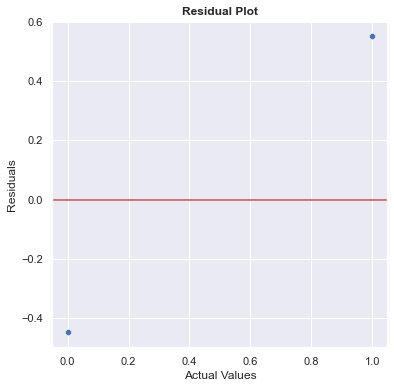

In [55]:
residuals = y_test - pred # residuals 

sns.scatterplot(x=y_test,y=residuals)
y = np.linspace(0,3500,100)
x = np.linspace(0,0)
plt.axhline(y=0, color='r', linestyle='-')
sns.set(rc = {'figure.figsize':(6,6)})
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residual Plot",fontweight="bold")

---
## 2.4.2 Linear Regression <a class="anchor" id="2.4.2"></a>

In [56]:
lr = LinearRegression() # instantiating the Knn regressor 
lr.fit(x_train,y_train) # Fitting train set to the model

lr_pred = lr.predict(x_test) # prediction on validation
lr_pred_tr = lr.predict(x_train) # prediction on train

# Scores
print("Training Set:")
print(f'R2 score = {r2_score(y_train,lr_pred_tr)}') 

print("--------------------------------")

print("Validation Set:")
print(f'R2 score = {r2_score(y_test,lr_pred)}')
print("Root Mean Square Error (RMSE) = ",np.sqrt(mean_squared_error(y_test,lr_pred)))

Training Set:
R2 score = 0.47369964383025454
--------------------------------
Validation Set:
R2 score = 0.43247966192524245
Root Mean Square Error (RMSE) =  0.37666972869967846


[Back to Contents](#Top)

---
## 2.4.3 Decision Tree <a class="anchor" id="2.4.3"></a>

In [57]:
regressor = DecisionTreeRegressor(random_state=42) # Instantiating the regressor 
regressor.fit(x_train, y_train) # Fitting the train set to the model

dc_pred_tr = regressor.predict(x_train) # Predictions on train
dc_pred = regressor.predict(x_test) # Predictions on Validation

# Scores
print("Training Set:")
print(f'R2 score = {r2_score(y_train,dc_pred_tr)}') 

print("--------------------------------")

print("Validation Set:")
print(f'R2 score = {r2_score(y_test,dc_pred)}')
print("Root Mean Square Error (RMSE) = ",np.sqrt(mean_squared_error(y_test,dc_pred)))

Training Set:
R2 score = 1.0
--------------------------------
Validation Set:
R2 score = 0.0
Root Mean Square Error (RMSE) =  0.5


In [58]:
start = time.time()

# Creating the parameter grid
max_depth = [int(x) for x in np.linspace(1,100,50)]
min_samples_split = [int(x) for x in np.linspace(1,100,100)]
min_samples_leaf = [int(x) for x in np.linspace(1,100,100)]

param_grid = {
    'max_depth': max_depth,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf
}
# Instantiating the grid search model
random_search_dt = RandomizedSearchCV(estimator = regressor, param_distributions = param_grid, n_iter = 100, 
                               cv = 5,random_state=42, n_jobs = -1)
random_search_dt.fit(x_train, y_train)

print(f'Best Hyperparameter value: {random_search_dt.best_estimator_}')
print("------------------------------------------------------------")
print(f'Time taken for randomsearchCV: {time.time() - start} seconds')

Best Hyperparameter value: DecisionTreeRegressor(max_depth=87, min_samples_leaf=5, min_samples_split=11,
                      random_state=42)
------------------------------------------------------------
Time taken for randomsearchCV: 1.8175621032714844 seconds


In [59]:
start = time.time()

# Creating the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [1,5,10,25,35,45,55,65,75,85],
    'min_samples_split' : [5,10,15,20,25,30,35],
    'min_samples_leaf' : [2,3,4,5,6,7,8]
}
# Instantiating the grid search model
grid_search_dt = GridSearchCV(estimator = regressor, param_grid = param_grid, 
                          cv = 5,n_jobs=-1)
grid_search_dt.fit(x_train, y_train)

print(f'Best Hyperparameter value: {grid_search_dt.best_estimator_}')
print("------------------------------------------------------------")
print(f'Time taken for GridSearchCV: {time.time() - start} seconds')

Best Hyperparameter value: DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                      random_state=42)
------------------------------------------------------------
Time taken for GridSearchCV: 1.2793657779693604 seconds


In [60]:
df = pd.DataFrame(data=grid_search_dt.cv_results_) # creating a dataframe to plot the hyperparameters
df.head() # displaying the head of the created dataframe

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002684,0.001510,0.000927,0.000040,1,2,5,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.55304,0.090232,0.173382,0.475362,0.50547,0.359497,0.189385,433
1,0.002358,0.001022,0.002338,0.001185,1,2,10,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.55304,0.090232,0.173382,0.475362,0.50547,0.359497,0.189385,433
2,0.001800,0.000325,0.001498,0.000598,1,2,15,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.55304,0.090232,0.173382,0.475362,0.50547,0.359497,0.189385,433
3,0.002598,0.001102,0.002133,0.001347,1,2,20,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.55304,0.090232,0.173382,0.475362,0.50547,0.359497,0.189385,433
4,0.002672,0.001110,0.000959,0.000136,1,2,25,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.55304,0.090232,0.173382,0.475362,0.50547,0.359497,0.189385,433


Text(0.5, 1.0, 'Max Depth')

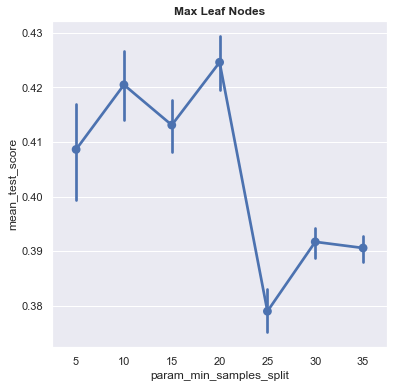

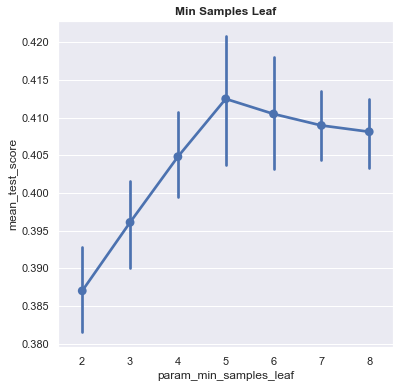

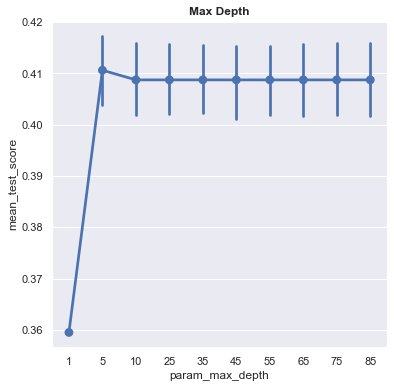

In [61]:
# Hyperparameter plots
fig,ax = plt.subplots()
sns.pointplot(data=df[['mean_test_score',
                           'param_min_samples_split',]],
             y='mean_test_score',x='param_min_samples_split',ax=ax)
sns.set(rc = {'figure.figsize':(6,6)})
plt.title("Max Leaf Nodes",fontweight="bold")

fig,ax = plt.subplots()
sns.pointplot(data=df[['mean_test_score',
                           'param_min_samples_leaf',]],
             y='mean_test_score',x='param_min_samples_leaf',ax=ax)
sns.set(rc = {'figure.figsize':(6,6)})
plt.title("Min Samples Leaf",fontweight="bold")

fig,ax = plt.subplots()
sns.pointplot(data=df[['mean_test_score',
                           'param_max_depth',]],
             y='mean_test_score',x='param_max_depth',ax=ax)
sns.set(rc = {'figure.figsize':(6,6)})
plt.title("Max Depth",fontweight="bold")


In [62]:
# Fitting the values of the obtained optimal hyperparameter
regressor = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                      random_state=42)  # Instantiating the regressor 
regressor.fit(x_train, y_train) # Fitting the train set to the model

dc_pred_tr = regressor.predict(x_train) # Predictions on train
dc_pred = regressor.predict(x_test) # Predictions on Validation

# Scores
print("Training Set:")
print(f'R2 score = {r2_score(y_train,dc_pred_tr)}') 

print("--------------------------------")

print("Validation Set:")
print(f'R2 score = {r2_score(y_test,dc_pred)}')
print("Root Mean Square Error (RMSE) = ",np.sqrt(mean_squared_error(y_test,dc_pred)))

Training Set:
R2 score = 0.6949327735292647
--------------------------------
Validation Set:
R2 score = 0.3259143518518517
Root Mean Square Error (RMSE) =  0.41051359543508065


> **Observations**
> - After evaluating he performance of the 3 models:
>> - Dummy regressor fails to fit the data
>> - Linear regression has a poor fit on the data
>> - Decision Tree overfits the data. To decrease the overfitting, hyperparameter tuning is performed, yet, the performance is poor on the test set. 

From the above, the models performed poorly on the data. So, onto the next approach.


[Back to Contents](#Top)

---
## 3. Approach III <a class="anchor" id="3"></a>
Classification Problem with feature generation. I Will be using the previously generated features and dataset.

In [63]:
final_df2.head()

,TPH,Hits,Day,Month,Holiday,Week,Winter,Spring,Summer,Autumn
0,750,0,1,5,0,1,0.0,1.0,0.0,0.0
1,750,1,2,5,1,0,0.0,1.0,0.0,0.0
2,750,0,3,5,0,0,0.0,1.0,0.0,0.0
3,750,1,4,5,0,0,0.0,1.0,0.0,0.0
4,750,0,5,5,0,0,0.0,1.0,0.0,0.0


---
## 3.1 Model Evaluation <a class="anchor" id="3.1"></a>


> I will be considering 1 Classification model:
> - Logistic Regression

I will evaluate the model and test it against unseen data if it performs well.

In [64]:
# X  = Other features, Y = Target feature
X = final_df2.loc[:, final_df2.columns != "Hits"]
Y = final_df2["Hits"]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42) # train - test split


print("Split ratio - 80:20")
print("--------------------------------------------------")
print("Train:",x_train.shape)
print("Test:",x_test.shape)

Split ratio - 80:20
--------------------------------------------------
Train: (212, 9)
Test: (24, 9)


[Back to Contents](#Top)

---
## 3.1.1 Logistic Regression <a class="anchor" id="3.1.1"></a>

In [65]:
model = LogisticRegression(random_state=42)
model.fit(x_train,y_train)

pred = model.predict(x_train)
pred_test = model.predict(x_test)

In [66]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.82      0.75      0.78        12

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.79      0.79      0.79        24



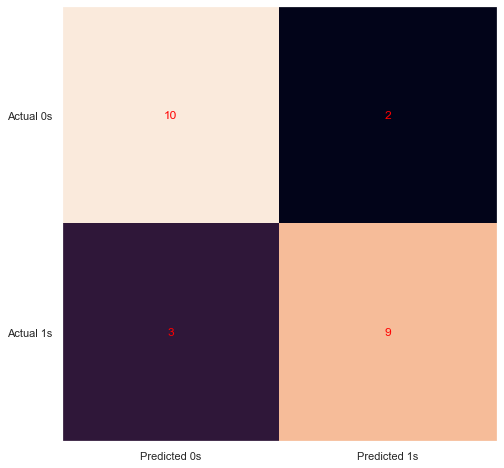

In [67]:
cm = confusion_matrix(y_test, pred_test)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

[Back to Contents](#Top)

> **Observations**
> - the classification approach works well on the data:
>> - Logistic Regression fits the data well, produces high accuracy on test data. 

This appraoch is good and now can be tested on unseen data for optimum TPH.

---
## 4. Unseen Data (Real - Test set) <a class="anchor" id="4"></a>

This data is generated in excel. The data contains 2 columns from the origianl data given, i.e, date and TPH. However, the changes are:
> - Data is for a year and not 6 months
> - Data is for the year 2023 so that the model doesn't overfit 
> - Each day has 3 values of TPH:
>> - 650
>> - 700
>> - 750
> - This data will be passed to the Logistic Regression model to make prediction whether there is a hit or not.
> - there will be 3 TPH results:
>> - Optimum TPH per Day Logic:
>>> - If all the 3 values of TPH have 1 (Hits > 4) then assign a random TPH
>>> - If atleast 1 TPH value has 0 (Hits <= 4) then make it the optimal TPH and remove the others
>>> - If all the 3 TPH values have 0 (Hits <= 4) then retain all the TPH values to be optimal. 
>> - Optimum TPH per Month Logic:
>>> - Groupby Month and find the most repeated (MODE) TPH value from the above logic and make it the optimal TPH value for that month. 
>> - Optimal TPH per Year Logic:
>>> - The most repeated TPH value (MODE) in the whole year is the optimum TPH

In [68]:
dft = pd.read_excel("Test data.xlsx")

In [69]:
dft.head()

,Date,TPH
0,2023-01-01,650
1,2023-01-01,700
2,2023-01-01,750
3,2023-01-02,650
4,2023-01-02,700


In [70]:
# extracting all features from the date to make the model predict 

# date -> month, day
dft['Day'] = dft['Date'].dt.day
dft['Month'] = dft['Date'].dt.month


In [71]:
# season feature for UK (Northern Hemisphere)

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'
    
dft['Season'] = dft['Month'].apply(get_season)

In [72]:
# Holidays

import holidays

uk_holidays = holidays.UnitedKingdom(years=2022)


dft['holidays'] = dft.Date.apply(lambda date: uk_holidays.get(date))
dft.holidays = dft.holidays.fillna('No holiday') 

In [73]:
holiday = []
for row in dft['holidays']:
    if row == "No holiday" :    
        holiday.append(0)
    else:          
        holiday.append(1)
            
dft['Holiday'] = holiday

In [74]:
# Weekday / Weekend
dft['Weekday'] = dft.Date.dt.weekday

dft["Weekday"].unique() # starts from Sunday

array([6, 0, 1, 2, 3, 4, 5])

In [75]:
week = []
for row in dft['Weekday']:
    if row <5 :    
        week.append("Weekday")
    elif row >=5:          
        week.append("Weekend")
            
dft['Week'] = week

In [76]:
# One hot encoding                  


# removing features that are not useful anymore
del dft["Weekday"]
del dft["holidays"]

# instantiated the one hot encoder 
encoder = OneHotEncoder()

# performed one-hot encoding on season column 
encoder_dft = pd.DataFrame(encoder.fit_transform(dft[['Season']]).toarray())

# merged one-hot encoded columns back with original DataFrame
final_dft = dft.join(encoder_dft)

# renamed the one hot encoded columns 
final_dft = final_dft.rename(columns={0: "Winter", 1: "Spring", 2: "Summer", 3: "Autumn"})
final_dft.head()

# deleted the existing seasons 
del final_dft["Season"]

# replaced Week and functioning day column with binary digits (since there are only two values)
final_dft['Week'] = final_dft['Week'].replace(['Weekday'], 0)
final_dft['Week'] = final_dft['Week'].replace(['Weekend'], 1)

del final_dft["Date"]

In [77]:
final_dft

,TPH,Day,Month,Holiday,Week,Winter,Spring,Summer,Autumn
0,650,1,1,1,1,0.0,0.0,0.0,1.0
1,700,1,1,1,1,0.0,0.0,0.0,1.0
2,750,1,1,1,1,0.0,0.0,0.0,1.0
3,650,2,1,1,0,0.0,0.0,0.0,1.0
4,700,2,1,1,0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
1090,700,30,12,0,1,0.0,0.0,0.0,1.0
1091,750,30,12,0,1,0.0,0.0,0.0,1.0
1092,650,31,12,0,1,0.0,0.0,0.0,1.0
1093,700,31,12,0,1,0.0,0.0,0.0,1.0


[Back to Contents](#Top)

---
## 4.1 Model Performance on Unseen Data <a class="anchor" id="4.1"></a>

In [78]:
x_test_final = final_dft

In [79]:
x_test_final.head()

,TPH,Day,Month,Holiday,Week,Winter,Spring,Summer,Autumn
0,650,1,1,1,1,0.0,0.0,0.0,1.0
1,700,1,1,1,1,0.0,0.0,0.0,1.0
2,750,1,1,1,1,0.0,0.0,0.0,1.0
3,650,2,1,1,0,0.0,0.0,0.0,1.0
4,700,2,1,1,0,0.0,0.0,0.0,1.0


In [80]:
model = LogisticRegression(random_state=42)
model.fit(x_train,y_train)

pred = model.predict(x_train)
pred_test_final = model.predict(x_test_final)

In [81]:
final_dft["Hits_predicted"] = pred_test_final
final_dft.head()

,TPH,Day,Month,Holiday,Week,Winter,Spring,Summer,Autumn,Hits_predicted
0,650,1,1,1,1,0.0,0.0,0.0,1.0,1
1,700,1,1,1,1,0.0,0.0,0.0,1.0,1
2,750,1,1,1,1,0.0,0.0,0.0,1.0,1
3,650,2,1,1,0,0.0,0.0,0.0,1.0,1
4,700,2,1,1,0,0.0,0.0,0.0,1.0,1


In [82]:
# final_dft.to_excel("/Users/bharathsimha/Desktop/Gatwick/final.xlsx") 
# to add date feature in excel and commented out once it is addded

---
## 5. Optimum TPH <a class="anchor" id="5"></a>

In [83]:
final = pd.read_excel("final.xlsx")
final.head()

,Unnamed: 0,Date,TPH,Hits_predicted
0,0,2023-01-01,650,1
1,1,2023-01-01,700,1
2,2,2023-01-01,750,1
3,3,2023-01-02,650,1
4,4,2023-01-02,700,1


In [84]:
del final["Unnamed: 0"]
final.head()

,Date,TPH,Hits_predicted
0,2023-01-01,650,1
1,2023-01-01,700,1
2,2023-01-01,750,1
3,2023-01-02,650,1
4,2023-01-02,700,1


In [85]:
# Finding the Optimum Value of TPH 
# Note: Compile only once, if you compile it twice, Compile from section 5. Optimum TPH again 

for date, date_df in final.groupby('Date'):
    if date_df['Hits_predicted'].sum() == 3 and 0 not in date_df['TPH'].values:
        hit_one_df = date_df[date_df['Hits_predicted'] == 1]
        if hit_one_df.shape[0] > 0:
            random_index = np.random.choice(hit_one_df.index)
            final.at[random_index, 'Hits'] = date_df.at[random_index, 'TPH']
            

#final['Hits'].fillna(0, inplace=True)
final.loc[final['Hits_predicted'] == 0, 'Hits'] = 0

final = final.dropna()
del final["Hits"]
del final["Hits_predicted"]
final["Optimum TPH"] = final["TPH"]
del final["TPH"]

[Back to Contents](#Top)

---
## 5.1 Optimum TPH per Day <a class="anchor" id="5.1"></a>

In [86]:
final # optimum TPH per day

,Date,Optimum TPH
0,2023-01-01,650
3,2023-01-02,650
6,2023-01-03,650
11,2023-01-04,750
13,2023-01-05,700
...,...,...
1090,2023-12-30,700
1091,2023-12-30,750
1092,2023-12-31,650
1093,2023-12-31,700


Text(0.5, 1.0, 'The Count of Optimal TPH')

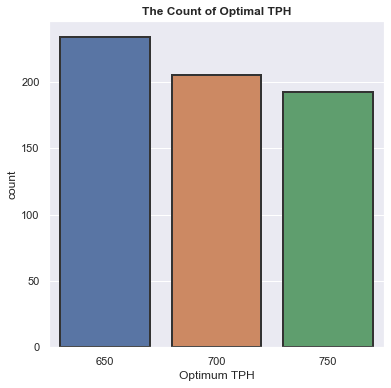

In [87]:
# plot showing the counts of Optimum TPH 

plt.figure(figsize=(6,6))
sns.countplot(x = "Optimum TPH", data = final,linewidth=2,edgecolor=".2")
plt.title("The Count of Optimal TPH",fontweight="bold")

---
## 5.2 Optimum TPH per Month <a class="anchor" id="5.2"></a>

In [88]:
final['Month'] = final['Date'].dt.month

In [89]:
final_by_month = final.groupby(["Month"]).agg(pd.Series.mode)
del final_by_month["Date"]

In [90]:
final_by_month # Most optimal TPH by month 

,Optimum TPH
Month,
1,650
2,"[650, 750]"
3,650
4,650
5,650
6,750
7,700
8,650
9,"[650, 700, 750]"


---
## 5.3 Optimum TPH per Year <a class="anchor" id="5.3"></a>

In [91]:
final["Optimum TPH"].mode() # most optimal TPH in the whole year

0    650
dtype: int64

**The optimum TPH per year is `650`**

[Back to Contents](#Top)

---
# 6. Conclusion <a class="anchor" id="6"></a>

I have successfully carried out the analysis and modelling required to answer the question. However, there are some challenges I encountered during this process:

**Challenges**
> - The major challenge was the size of the dataset. Due to the smaller size of the dataset, the regression models did not get enough training data for good performance. 
> - Another major challenge is the lack of features in the dataset. Due to the features being TPH and Hits, in which hits is a target/dependednt feature the models struggled to understand the context of TPH and Hits and failed to establish a relatioship between them. This is why once I generated new features from the date column and the models performed slightly better.

# The Notebook Ends Here



---